### Imports

In [1]:
import pandas as pd
from pandasql import sqldf
import time
import matplotlib.pylab as plt
import numpy as mp


##Spacy function
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame

## Train and test
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

## Performance
from sklearn import metrics
from sklearn.metrics import classification_report

## Models
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier



### Dataset original

In [2]:
df = pd.read_csv('cnnchile_7000.csv')
df = df.drop(["country","media_outlet", "url","date","title"],1)

q="""SELECT category, count(*) FROM df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,tendencias,1000
1,tecnologias,1000
2,pais,1000
3,mundo,1000
4,economia,1000
5,deportes,1000
6,cultura,1000


### Test and Train Split

In [26]:
## PRUEBAS REALES

X = df['text'].astype(str)
ylabels = df['category'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.25, random_state=0)


### Spacy function

In [6]:
nlp = spacy.load("es_core_news_md")
def feature_extraction(text):
    
    mytokens = nlp(text)

    #Guardamos las palabras como características si corresponden a ciertas categorias gramaticaless
    mytokens = [ word for word in mytokens if word.pos_ in ["NOUN", "ADJ", "VERB"] ]
    
    #Transformamos las palabras en minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # return preprocessed list of tokens
    return mytokens

### Regresión logistica utilizando CountVectorizer vs TfidfVectorizer 

Al usar **countVectorizer**, utilizamos un enfoque `bag of word` donde cada palabra tiene la cantidad de veces que la palabra aparece en el texto (count)

Al usar **TfidfVectorizer** cambiamos el enfoque **countVectorizer** a un enfoque `Term frequency (tf)` y `Inverse data frequency (idf)` por lo cual a la estructura anterior se reemplaza el enfoque de conteo por la frecuencia que tenga esa palabra en el texto de la fila.

Este enfoque es importante debido a que disminuimos la importancia de palabras comunes dentro de nuestro bag of words, así por ejemplo palabras como *"el, la, como"* son menos propensas a afectar en el resultado final


In [7]:
bow_vector = CountVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

tfidf_vector = TfidfVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

In [228]:
model_1 = LogisticRegression(max_iter=1000)

pipe1 = Pipeline([('vectorizing', bow_vector),
                 ('learning', model_1)])


pipe2 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_1)])

In [9]:
pipe1.fit(X_train,y_train)

pipe2.fit(X_train,y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning', LogisticRegression(max_iter=1000))])

In [10]:
predicted_model_1 = pipe1.predict(X_test) 

In [11]:
predicted_model_2 = pipe2.predict(X_test)

In [12]:
print("Logistic Regression using CountVectorizer:",metrics.accuracy_score(y_test, predicted_model_1))

print("Logistic Regression using TfidfVectorizer:",metrics.accuracy_score(y_test, predicted_model_2))

Logistic Regression using CountVectorizer: 0.7222857142857143
Logistic Regression using TfidfVectorizer: 0.772


In [13]:
print("Matriz de confusión para CountVectorizer: ")
print(classification_report(y_test, predicted_model_1))

Matriz de confusión para CountVectorizer: 
              precision    recall  f1-score   support

     cultura       0.59      0.97      0.74       250
    deportes       0.86      0.78      0.82       255
    economia       0.74      0.82      0.78       273
       mundo       0.72      0.71      0.72       238
        pais       0.80      0.58      0.68       250
 tecnologias       0.69      0.72      0.70       252
  tendencias       0.79      0.43      0.56       232

    accuracy                           0.72      1750
   macro avg       0.74      0.72      0.71      1750
weighted avg       0.74      0.72      0.72      1750



In [14]:
print("Matriz de confusión para TfidfVectorizer: ")
print(classification_report(y_test, predicted_model_2))

Matriz de confusión para TfidfVectorizer: 
              precision    recall  f1-score   support

     cultura       0.87      0.90      0.89       250
    deportes       0.85      0.87      0.86       255
    economia       0.77      0.78      0.78       273
       mundo       0.72      0.72      0.72       238
        pais       0.78      0.68      0.72       250
 tecnologias       0.72      0.72      0.72       252
  tendencias       0.69      0.72      0.70       232

    accuracy                           0.77      1750
   macro avg       0.77      0.77      0.77      1750
weighted avg       0.77      0.77      0.77      1750



#### Comentarios

Podemos apreciar una clara diferencia entre la implementación de **LogisticRegression** utilizando `CountVectorizer` con la de `TfidfVectorizer`, para realizar esta comparación compararemos por separado los resultados de f1-score, con los de precision y recall, pero para ambos casos nos enfocaremos en las 2 clases las cuales tienen un cambio más significativo, **cultura**, **deportes**.

* **f1-score:**  Podemos apreciar claramente que en todas las clases, Tfidf fue mejor, y en las 2 clases más problemáticas pudo mejorar el rendimiento de manera considerable, donde en cultura, pasó de un score de 0.74 a 0.89 y en tendencias de 0.56 a 0.70.


* **precision y recall:**  En la primera implementación, podemos observar una clara diferencia en la precision y recall de las clases **cultura** y **deportes**. En la clase cultura, podemos ver que existe un valor de recall sumamente bueno, pero un modesto valor de precision, por lo que podemos inferir que el método está efectuando una mayor cantidad de falsos positivos que falsos negativos, y en la clase tendencias, podemos ver el caso contrario, debido a que el valor de precision es mayor muy bueno en comparación de recall. Este problema, es solucionado en la segunda implementación, pudiendo normalizar estos scores, haciendo así una mejora en el valor de accuracy.

Por lo que podemos concluir que la segunda implementación es considerablemente mejor que la primera.
Una razón de esta mejora, es que `TfidfVectorizer` le baja la importancia a las palabras comunes, por lo que es probable que en estas 2 clases, exista una gran cantidad de palabras comunes, haciendo que el modelo sea capaz de clasificar de mejor manera.



### Decision Tree vs Random Forest

In [27]:
model_2 = tree.DecisionTreeClassifier()
model_3 = clf = RandomForestClassifier(n_estimators=700,
                                       max_depth=None, 
                                       random_state=0)

pipe3 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_2)])

pipe4 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_3)])

In [28]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning', DecisionTreeClassifier())])

In [29]:
pipe4.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning',
                 RandomForestClassifier(n_estimators=700, random_state=0))])

In [30]:
predicted_model_2 = pipe3.predict(X_test) 

In [31]:
predicted_model_3 = pipe4.predict(X_test) 

In [35]:
print("Accuracy Decision Tree:",metrics.accuracy_score(y_test, predicted_model_2))

print("Accuracy Random Forest:",metrics.accuracy_score(y_test, predicted_model_3))

Accuracy Decision Tree: 0.5422857142857143
Accuracy Random Forest: 0.7325714285714285


In [36]:
print("Matriz de confusión para Decision Tree: ")
print(classification_report(y_test, predicted_model_2))

Matriz de confusión para Decision Tree: 
              precision    recall  f1-score   support

     cultura       0.73      0.69      0.71       250
    deportes       0.73      0.73      0.73       255
    economia       0.57      0.54      0.56       273
       mundo       0.39      0.44      0.41       238
        pais       0.38      0.38      0.38       250
 tecnologias       0.56      0.53      0.54       252
  tendencias       0.45      0.48      0.46       232

    accuracy                           0.54      1750
   macro avg       0.54      0.54      0.54      1750
weighted avg       0.55      0.54      0.54      1750



In [37]:
print("Matriz de confusión para Random Forest: ")
print(classification_report(y_test, predicted_model_3))

Matriz de confusión para Random Forest: 
              precision    recall  f1-score   support

     cultura       0.80      0.91      0.85       250
    deportes       0.79      0.88      0.83       255
    economia       0.74      0.74      0.74       273
       mundo       0.73      0.63      0.68       238
        pais       0.64      0.67      0.66       250
 tecnologias       0.73      0.66      0.70       252
  tendencias       0.68      0.62      0.65       232

    accuracy                           0.73      1750
   macro avg       0.73      0.73      0.73      1750
weighted avg       0.73      0.73      0.73      1750



#### Comentarios

A partir de los resultados podemos apreciar una clara mejora al implementar `RandomForestClassifier`, esto probablemente esto es debido a que algoritmo de `DecisionTree`, no es capaz de seleccionar bien las clases debido a la implementación **bag of words**. Una solución para esto, fue implementar `RandomForestClassifier` con un valor de **n_estimators** de 750, por lo que se crean 750 árboles de decisión, los cuales son utilizados para definir a qué clase pertenece cada observación de *x_test*.

Es probable que pueda existir un mejor valor de accuracy realizando un mejor **parameter tuning**, con los valores de Random Forest, debido a que solo se modificó el parámetro anteriormente descrito, pero pese a esto, la accuracy de este algoritmo es muy cercano al de `LogisticRegression`


# Otros modelos 


* Realizaremos pruebas de otros modelos de aprendizaje.Estos modelos son:
> * SGDClassifier
> * KNN (K-nearest Neighbor)

Además a estos modelos se les aplicará un pequeño algoritmo para determinar los mejores parametros y por ende tener sus mejores valores de accuracy.



## SGDClassifier

In [183]:
model_4 = SGDClassifier(loss='hinge', 
              penalty='l2', 
              alpha=1e-3, 
              random_state=None,
              max_iter=1000, 
              tol=None)

pipe5 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_4)])


In [184]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning', SGDClassifier(alpha=0.001, tol=None))])

In [185]:
predicted_model_4 = pipe5.predict(X_test) 

In [186]:
# Exactitud del modelo.
print("SGDClassifier Accuracy:",metrics.accuracy_score(y_test, predicted_model_4))

SGDClassifier Accuracy: 0.7634285714285715


In [187]:
print(classification_report(y_test, predicted_model_4))

              precision    recall  f1-score   support

     cultura       0.79      0.95      0.86       250
    deportes       0.84      0.92      0.88       255
    economia       0.75      0.85      0.79       273
       mundo       0.74      0.71      0.73       238
        pais       0.77      0.63      0.69       250
 tecnologias       0.71      0.71      0.71       252
  tendencias       0.73      0.55      0.63       232

    accuracy                           0.76      1750
   macro avg       0.76      0.76      0.76      1750
weighted avg       0.76      0.76      0.76      1750



## Determinar los mejores parametros usando

### Logistic Regression best C parameter and run time 

In [194]:
Cparameters = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10, 100, 1000]

accList = []
maxAcc = 0
start = time.time() 
for i in range (len(Cparameters)):
    model_1 = LogisticRegression(max_iter=1000, C=float(Cparameters[i]), n_jobs=-1)
    
    pipe2 = Pipeline([('vectorizing', tfidf_vector),
                      ('learning', model_1)])
    
    pipe2.fit(X_train, y_train)

    predicted_model_1 = pipe2.predict(X_test) 
    
    t = float(metrics.accuracy_score(y_test, predicted_model_1))
    accList.append(t)
    
    if  (t > maxAcc):
        maxAcc = metrics.accuracy_score(y_test, predicted_model_1)
    print(f" C parameter : {str(Cparameters[i])}, accucary : {t}")
       
print("Mejor accuracy usando el mejor C value: ", maxAcc)
end = time.time()
print("tiempo elegir mejor:" + str(int(end - start)), "segundos")


 C parameter : 0.0001, accucary : 0.13257142857142856
 C parameter : 0.001, accucary : 0.20057142857142857
 C parameter : 0.01, accucary : 0.7182857142857143
 C parameter : 0.1, accucary : 0.76
 C parameter : 1.0, accucary : 0.772
 C parameter : 10, accucary : 0.772
 C parameter : 100, accucary : 0.7662857142857142
 C parameter : 1000, accucary : 0.7645714285714286
Mejor accuracy usando el mejor C value:  0.772
tiempo elegir mejor:1935 segundos


### SGDC best learning rate and run time

In [195]:

learningRateList = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0] # learning rate

accList = []
maxAcc = 0
start = time.time() 
for i in range (len(learningRateList)):
    model_4 = SGDClassifier(loss='hinge', 
              penalty='l2', 
              alpha= float(learningRateList[i]), 
              random_state=None, n_jobs=-1)
    
    pipe5 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_4)])
    
    pipe5.fit(X_train, y_train)

    predicted_model_4 = pipe5.predict(X_test) 
    
    t = float(metrics.accuracy_score(y_test, predicted_model_4))
    accList.append(t)
    
    if  (t > maxAcc):
        maxAcc = metrics.accuracy_score(y_test, predicted_model_4)
    print(f" learing rate : {float(learningRateList[i]):.5f}, accucary : {t}")
       
print("Mejor accuracy usando el mejor learning rate: ", maxAcc)
end = time.time()
print("tiempo elegir mejor:" + str(int(end - start)), "segundos")


 learing rate : 0.00000, accucary : 0.7405714285714285
 learing rate : 0.00000, accucary : 0.7382857142857143
 learing rate : 0.00001, accucary : 0.7411428571428571
 learing rate : 0.00010, accucary : 0.7685714285714286
 learing rate : 0.00100, accucary : 0.76
 learing rate : 0.01000, accucary : 0.7474285714285714
 learing rate : 0.10000, accucary : 0.6491428571428571
 learing rate : 1.00000, accucary : 0.22685714285714287
Mejor accuracy usando el mejor learning rate:  0.7685714285714286
tiempo elegir mejor:1872 segundos


### Conclusiones

Podemos observar en función de su valor de accuracy, que es posible parametrizar `SGDClassifier` de tal manera que obtenga un rendimiento muy similar a `LogisticRegression`, para poder llegar a este valor, se modifica el parámetro **alpha** de `SGDClassifier`, el cual es un parámetro regularizador y además define la tasa de aprendizaje inicial, por lo que al definir valores de alpha más pequeños, es posible obtener mejores valores, pero por contrapartes es más lento a la hora de realizar el fit.

Cabe destacar, que en la teoría, esperábamos obtener un tiempo de ejecución mucho menor en el algoritmo de `SGDClassifier` debido a que SGDClassifier es un clasificador lineal generalizado que utilizará Stochastic Gradient Descent y LogisticRegression no, si no que implementa una regresión logística logarítmica regularizada por lo que minimiza la probabilidad logarítmica. Pero este no fue el caso, ambos algoritmos tienen tiempos de ejecución similar, por lo que la decisión de que modelo elegir no es clara, debido a que ambos algoritmos tienen un score muy similar.




### KNN (K-nearest Neighbor)


In [190]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [196]:
vecinos = range(29,45)
accList = []
maxAcc = 0
start = time.time() 

for vecino in vecinos:
    model_5 = KNeighborsClassifier(vecino, n_jobs=4)

    pipe6 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_5)])
    pipe6.fit(X_train, y_train)

    predicted_model_5 = pipe6.predict(X_test) 
    
    t = float(metrics.accuracy_score(y_test, predicted_model_5))
    accList.append(t)
    
    if  (t > maxAcc):
        maxAcc = metrics.accuracy_score(y_test, predicted_model_5)
    print(f" N : {int(vecino)}, accucary : {t}")
    
end = time.time()
       
print("Mejor accuracy usando el mejor vecino: ", maxAcc)
end = time.time()
print("tiempo elegir mejor:" + str(int(end - start)), "segundos")


 N : 29, accucary : 0.7394285714285714
 N : 30, accucary : 0.7405714285714285
 N : 31, accucary : 0.7411428571428571
 N : 32, accucary : 0.7405714285714285
 N : 33, accucary : 0.74
 N : 34, accucary : 0.7388571428571429
 N : 35, accucary : 0.7411428571428571
 N : 36, accucary : 0.7394285714285714
 N : 37, accucary : 0.744
 N : 38, accucary : 0.7451428571428571
 N : 39, accucary : 0.7502857142857143
 N : 40, accucary : 0.7462857142857143
 N : 41, accucary : 0.7451428571428571
 N : 42, accucary : 0.7462857142857143
 N : 43, accucary : 0.7462857142857143
 N : 44, accucary : 0.7457142857142857
Mejor accuracy usando el mejor vecino:  0.7502857142857143
tiempo elegir mejor:3897 segundos


### Conclusiones

Podemos observar que el accuracy de KNN es bastante cercano al mejor (LogisicRegresion), siendo este de 0.7502, utilizando 39 vecinos.

Cabe destacar que este método es bastante más costoso a nivel computacional y la elección de el valor de k, no es muy facil de determinar, debido a que en nuestro caso, la diferencia entre cada valor de k no es tan radical como en los modelos pasados, donde en cada iteración habia un notorio aumento de decrecimiento del valor de accuracy.


## Conclusiones generales

Podemos apreciar que todos los modelos implementados tienen valores de accuracy bastante similares y a juicio personal bastante buenos, por lo que creo que implementar alguno de estos métodos tradicionales es bastante óptimo para el problema en cuestión.

Si se tuviera que seleccionar un método en concreto, seleccionaría `SGDClassifier`, debido a que al no ser el que determinó el mejor valor de accuracy, este tiene un menor costo computacional. Además que los parámetros que tiene, dan la posibilidad de hacer un parameter tuning mucho mejor que LogisticRegression.


### INTENTO DE IMPLEMENTAR BETO DCCUCHILE (NO FUNCIONA)


* La intención era realizar una implementación de BETO (Bert entrenado en español https://github.com/dccuchile/beto) para la clasificación de textos, pero no funciona (lo dejo por si acaso).

###### Acotar el dataset

In [3]:
q="""SELECT * FROM df WHERE category = "tendencias";"""
df_tend=sqldf(q)

df_tend = df_tend.sample(n=100)

q="""SELECT * FROM df WHERE category = "tecnologias";"""
df_tech = sqldf(q)

df_tech = df_tech.sample(n=100)


q="""SELECT * FROM df WHERE category = "pais";"""
df_pais=sqldf(q)

df_pais = df_pais.sample(n=100)

q="""SELECT * FROM df WHERE category = "mundo";"""
df_mundo=sqldf(q)

df_mundo = df_mundo.sample(n=100)

q="""SELECT * FROM df WHERE category = "economia";"""
df_eco=sqldf(q)

df_eco = df_eco.sample(n=100)

q="""SELECT * FROM df WHERE category = "deportes";"""
df_dep = sqldf(q)

df_dep = df_dep.sample(n=100)

q="""SELECT * FROM df WHERE category = "cultura";"""
df_cult = sqldf(q)

df_cult = df_cult.sample(n=100)

df = pd.concat([df_tend, df_tech, df_pais, df_mundo,df_eco,df_dep,df_cult], ignore_index=True)
df.shape


(700, 2)

In [4]:
## Reemplazamos las categorias por valores numeros debido a que tensor no aceptar strings.

df['category'] = df['category'].str.replace('cultura','0')
df['category'] = df['category'].str.replace('deportes','1')
df['category'] = df['category'].str.replace('economia','2')
df['category'] = df['category'].str.replace('mundo','3')
df['category'] = df['category'].str.replace('pais','4')
df['category'] = df['category'].str.replace('tecnologias','5')
df['category'] = df['category'].str.replace('tendencias','6')

df['category'] = df['category'].astype(int)



In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import BertForMaskedLM, BertTokenizer

# Usamos cuda para poder utilizar GPU
device = torch.device("cuda")

In [6]:
##Se realiza un split del dataset

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['category'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['category'])

In [7]:
# CrossValidation
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [8]:
# Evaluar el modelo y crear el tokenizador

tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)
bert = BertForMaskedLM.from_pretrained("pytorch/")
bert.eval()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [9]:
# Texto de ejemplo
text = ['Confución generaron los datos entregados por la Oficina Nacional de Emergencia con respecto a la cantidad de casas afectadas por el incendio en la comuna de Parral. La primera información oficial fue entregada este miércoles un cuarto para la 1 de la madrugada, donde se aseguraba había 40 viviendas destruidas. Sin embargo, pasadas las 19:30 del mismo día hicieron la siguiente declaración. Desde el Gobierno se justificaron y afirman que la Onemi no incurrió en error, puesto que siempre se habló de un número “provisorio”. Los detalles en el video adjunto.  ','Una nueva polémica tiene esta carrera presidencial. El sobrino del Alejandro Navarro y actual candidato a Core, Eduardo Hernández Navarro, intentó funar un acto de Sebastián Piñera en Concepción. Según indicó radio Biobío, el hecho ocurrió este lunes en las cercanías del Parque Ecuador en Concepción, donde el abanderado de Chile Vamos realizaba un encuentro con gente de la zona. Posteriormente, miembros del equipo de seguridad de Piñera retiraron a Hernández del lugar y luego Carabineros lo mantuvo retenido. Revisa parte de esta acción en el video adjunto.']


In [10]:
sent_id = tokenizer.batch_encode_plus(text, padding=True, 
                                      return_token_type_ids=False)

In [11]:
## Para ver como funciona batch_enconde_plus
print(sent_id)

{'input_ids': [[4, 9741, 1587, 12359, 1022, 1065, 2521, 29221, 1096, 1030, 3884, 3283, 1008, 28717, 1051, 2440, 1013, 1030, 3990, 1008, 6976, 10986, 1096, 1040, 11707, 1036, 1030, 11997, 1008, 1561, 2411, 1009, 1198, 2076, 1924, 3844, 1341, 7217, 1093, 1365, 13107, 1049, 4181, 1110, 1030, 1094, 1008, 1030, 22094, 1017, 1748, 1062, 15744, 1213, 1824, 3242, 8708, 21142, 30934, 1009, 2169, 2415, 1017, 24268, 1089, 1242, 1181, 2101, 1072, 1698, 1726, 5353, 1030, 2435, 4428, 1009, 3217, 1040, 2684, 1062, 14596, 1022, 1042, 21606, 1038, 1030, 17087, 1155, 1084, 11920, 2852, 1036, 5029, 1017, 3134, 1038, 2032, 1062, 10470, 1008, 1049, 2272, 3, 5280, 15459, 3, 1009, 1412, 7113, 1036, 1040, 6128, 16607, 1009, 5], [4, 1965, 2744, 24783, 1512, 1359, 4190, 15122, 1009, 1162, 15473, 1072, 12630, 26955, 1042, 3627, 9738, 1013, 2167, 30931, 1017, 12593, 18253, 26955, 1017, 11274, 1545, 1018, 1049, 5983, 1008, 16174, 5552, 13961, 1048, 1036, 18834, 1009, 3678, 14351, 4707, 12923, 7920, 30933, 1017, 10

<AxesSubplot:>

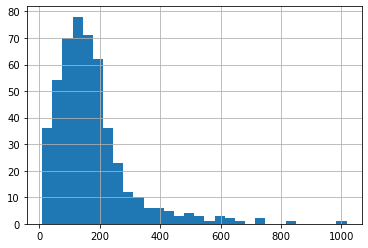

In [12]:
# Graficamos para determinar el largo maximo de las frases, se detemrina la mayoria tienen un
# largo máximo de 200.
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [13]:
max_seq_len = 200

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/matias/miniconda3/envs/IA/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:


# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())



In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [17]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [18]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      (_, cls_hs) = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [19]:

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)



In [20]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1. 1. 1. 1. 1. 1.]


/home/matias/miniconda3/envs/IA/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=545    1
320    3
39     6
344    3
396    3
      ..
292    4
147    5
161    5
300    3
455    2
Name: category, Length: 490, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [22]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [23]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model pred ictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [24]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


ValueError: not enough values to unpack (expected 2, got 1)

### Conclusiones

Pese a que no funciona, la intención era comprabar que tan optimos son los metodos tradicionales en comparación a BERT, modelo sumamente popular debido a sus buenos resultados, el analisis no pudo ser concretado debido a un error que no pude resolver, pero se seguirá con la intención de poder solucionarlo.